# Classification of Pollen on Bees
### M. Johnson, Feb. 25, 2019

TODO: 
    - try to visualize layers like in:
        - https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0
    
Feb. 25:
    Changes:
    - lr=0.0005 
    - added third fully connected layer, boosted acc
        - make sure this isn't just because of the distribution in validation sets?
    

In [1]:
%matplotlib inline
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pip install opencv-python
import cv2 as cv

#### Dataset
Here we create a custom Dataset object, PollenDataset, to store our data.

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

# 
class PollenDataset(Dataset):
    """class for Pollen dataset."""
    
    # 'pollen_data.csv', base_path
    def __init__(self, csv_file, root_dir, transform=None):
        '''
        '''
        self.root_dir = root_dir
        self.imlist = glob.glob(os.path.join(root_dir, 'images', '*.jpg'))
        self.dataframe = pd.read_csv(csv_file, index_col=0)
        
        self.transform = transform
        self.size =(180,300)
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        '''
        '''
        img_name = os.path.join(self.root_dir,
                                'images',
                                self.dataframe.iloc[idx, 0])
        
        image = cv.imread(img_name)
        image2 = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        image = cv.resize(image2, self.size)

        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        return (image, label)
    

# Class to display random images and labels
# data: Dataset object
def show_random_samples(data):
    
    label_dict = {0: 'No pollen', 1: 'Pollen'}
    fig = plt.figure(figsize=(12, 5))
    
    for i in range(6):
        plt.subplot(1,6,i+1)
        plt.tight_layout()
        
        idx = np.random.randint(len(data))
        image, label = data[idx]
        
        plt.imshow(image, cmap='gray', interpolation='none')
        plt.title(label_dict[label])
        plt.xticks([])
        plt.yticks([])
    fig
    

### Instantiate the PollenDataset:

In [3]:
pollen_data = PollenDataset(csv_file='pollen_data.csv',
                            root_dir='/home/mjohnson/Assignment2/PollenDataset')

#### A look at some samples:

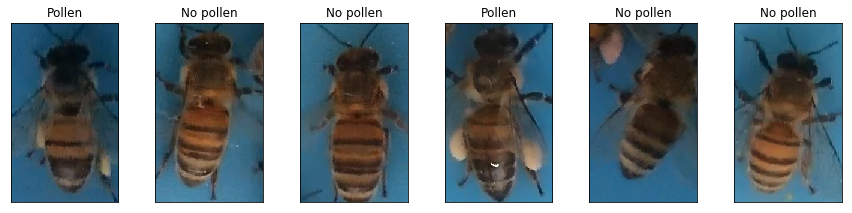

In [4]:
show_random_samples(pollen_data)

### Model Building:
- 3 Conv layers
- 3 Fully connected layers
- Relus
- 4 MPs

In [5]:
# CNN
#
import torch.nn as nn

class BeeNet(nn.Module):
    def __init__(self):
        super(BeeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(64, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*9*17, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 16*9*17)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

    def name(self):
        return "BeeNet_f25_gpu_3"

### Model training:
- Note: creates different training/validation sets each time so not to be used with loaded model unless we specify validation set:
    - TODO: specify validation set in way to reuse 

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

def get_training_and_validation_loaders(dataset):
    batch_size = 16
    validation_split = .2
    shuffle_dataset = True
    random_seed = 8

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    
    return train_loader, validation_loader       

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 
train_loader, validation_loader = get_training_and_validation_loaders(pollen_data)

In [8]:
# HPs
lr = 0.0005

# Model
model = BeeNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_list = []
acc_list = []
train_losses = []

#
num_epochs = 50
for epoch in range(num_epochs):
    # Train:   
    for batch_index, (images, labels) in enumerate(train_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.permute(0, 3, 2, 1).float())
        
        # Loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
                        
    with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # 
            images, labels = images.to(device), labels.to(device)
            images.permute(0, 3, 2, 1).float()
            
            # Forward pass
            outputs = model(images.permute(0, 3, 2, 1).float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
    
        acc = np.round(correct/total, 3)
        loss = np.mean(losses)
        
        acc_list.append(acc)
        loss_list.append(loss)
            
        #try:
            #print(f'Step [{epoch+1}/{num_epochs}]')
            #print(f'Loss: {np.mean(losses):.4}, Acc: {correct/total:.2f}')
        #except:
        print('Step', epoch+1, '/', num_epochs, '  ',
              'Loss:', np.round(np.mean(losses), 2), 'Acc:', np.round((correct/total), 2))
            #print('correct:', correct, 'total:', total)

Step 1 / 50    Loss: 0.7 Acc: 0.52
Step 2 / 50    Loss: 0.69 Acc: 0.5
Step 3 / 50    Loss: 0.69 Acc: 0.49
Step 4 / 50    Loss: 0.58 Acc: 0.74
Step 5 / 50    Loss: 0.57 Acc: 0.78
Step 6 / 50    Loss: 0.5 Acc: 0.71
Step 7 / 50    Loss: 0.35 Acc: 0.86
Step 8 / 50    Loss: 0.44 Acc: 0.81
Step 9 / 50    Loss: 0.31 Acc: 0.88
Step 10 / 50    Loss: 0.32 Acc: 0.87
Step 11 / 50    Loss: 0.3 Acc: 0.89
Step 12 / 50    Loss: 0.39 Acc: 0.85
Step 13 / 50    Loss: 0.27 Acc: 0.88
Step 14 / 50    Loss: 0.3 Acc: 0.89
Step 15 / 50    Loss: 0.26 Acc: 0.89
Step 16 / 50    Loss: 0.34 Acc: 0.89
Step 17 / 50    Loss: 0.3 Acc: 0.89
Step 18 / 50    Loss: 0.22 Acc: 0.92
Step 19 / 50    Loss: 0.25 Acc: 0.89
Step 20 / 50    Loss: 0.28 Acc: 0.9
Step 21 / 50    Loss: 0.27 Acc: 0.92
Step 22 / 50    Loss: 0.27 Acc: 0.89
Step 23 / 50    Loss: 0.3 Acc: 0.89
Step 24 / 50    Loss: 0.34 Acc: 0.9
Step 25 / 50    Loss: 0.45 Acc: 0.88
Step 26 / 50    Loss: 0.34 Acc: 0.87
Step 27 / 50    Loss: 0.29 Acc: 0.92
Step 28 / 50    Los

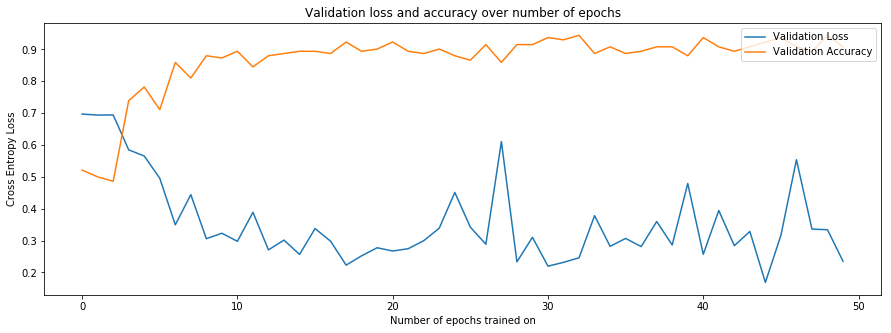

In [9]:
plt.subplots(figsize=(15,5))
plt.plot(loss_list); # blue
plt.plot(acc_list); # orange
plt.title('Validation loss and accuracy over number of epochs');
plt.xlabel('Number of epochs trained on');
plt.ylabel('Cross Entropy Loss');
plt.legend(['Validation Loss', 'Validation Accuracy'], loc='upper right');

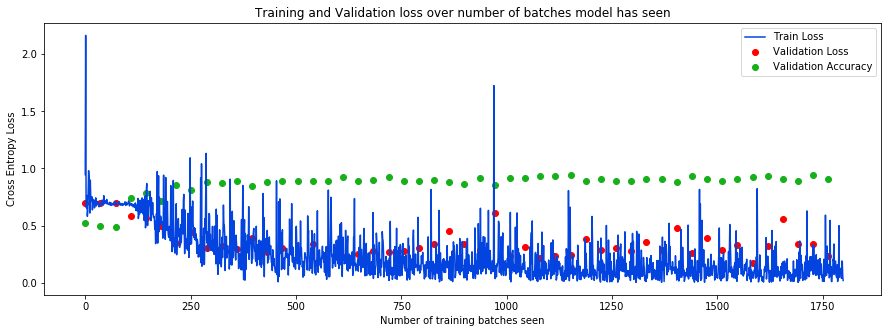

In [10]:
loader_len = len(train_loader)
x_vals= [loader_len*i for i in range(num_epochs)]
y_vals = loss_list

plt.subplots(figsize=(15,5))
plt.plot(train_losses, color='xkcd:blue');
plt.scatter(x=x_vals, y=loss_list, color='red'); # validation losses
plt.scatter(x=x_vals, y=acc_list, color='xkcd:green') # accs
plt.title('Training and Validation loss over number of batches model has seen');
plt.xlabel('Number of training batches seen');
plt.ylabel('Cross Entropy Loss');
plt.legend(['Train Loss', 'Validation Loss', 'Validation Accuracy'], loc='upper right');

In [11]:
torch.save(model.state_dict(), 'f25_BeeNet3.pth')
torch.save(optimizer.state_dict(), 'f25_optim3.pth')

In [12]:
## Not working on server, something with .cuda() -> .cpu() -> .numpy() and/ or memory allocation issues

In [13]:
def show_predictions():
    
    with torch.no_grad():
    
        # Chooose a random batch from validation loader to predict
        which_iter = np.random.randint(len(validation_loader))
        valid_iter = iter(validation_loader)
        for i in range(which_iter-1):
            next(valid_iter)

        # Fetch images and labels from batch
        images, labels = next(valid_iter)
        images, labels = images.to(device), labels.to(device)
        # 
        outputs = model(images.permute(0, 3, 2, 1).float())
        predictions = torch.max(outputs, 1)[1]
        predictions = predictions.cpu().numpy()

        labels = labels.cpu().numpy()

        # Dict for Labelling Images
        label_dict = {0: 'No pollen', 1: 'Pollen'}
        color_dict = {True: 'green', False: 'red'}
        
        fig = plt.figure(figsize=(15, 6))

        for i in range(12):
            plt.subplot(2,6,i+1)
            plt.tight_layout()

            image, label, pred = images[i], labels[i], predictions[i]

            plt.imshow(image.cpu().numpy(), cmap='gray', interpolation='none')
            
            plt.title('Label:' + label_dict[label] + '\nPred:' + label_dict[pred], 
                      color=color_dict[(label_dict[label] == label_dict[pred])])
            plt.xticks([])
            plt.yticks([])
        fig

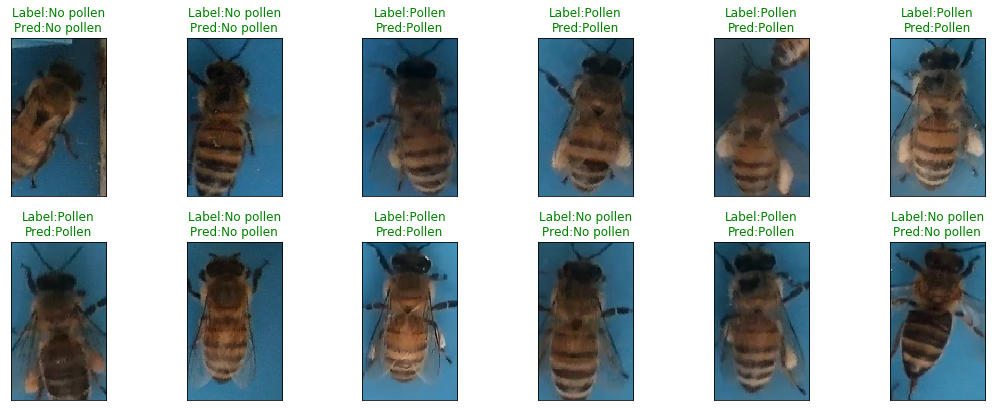

In [14]:
show_predictions()

<Figure size 432x288 with 0 Axes>

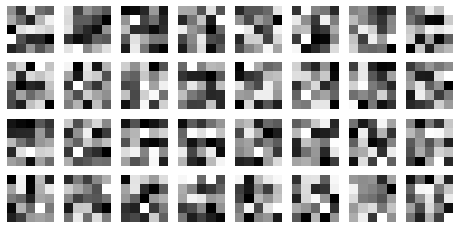

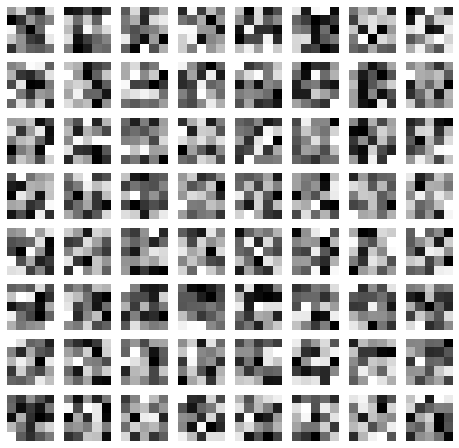

In [15]:
# code from: 
# https://medium.com/ml2vec/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset-e589682df0c5
def plot_kernels(tensor, num_cols=6):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0,:,:], cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
filters = model.modules();
model_layers = [i for i in model.children()];
first_layer = model_layers[0];
second_layer = model_layers[1];
first_kernels = first_layer.weight.data.cpu().numpy()
plot_kernels(first_kernels, 8);
second_kernels = second_layer.weight.data.cpu().numpy()
plot_kernels(second_kernels, 8);

In [16]:
first_layer.weight.data.cpu().numpy().shape

(32, 3, 5, 5)

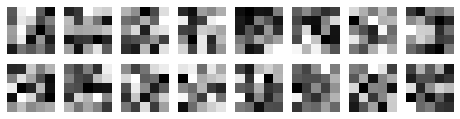

In [17]:
third_layer = model_layers[3];
third_kernels = third_layer.weight.data.cpu().numpy()
plot_kernels(third_kernels, 8);

In [18]:
second_kernels.shape

(64, 32, 5, 5)

In [19]:
third_kernels.shape

(16, 64, 5, 5)

with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # ...
            images, labels = images.to(device), labels.to(device)
            images.permute(0, 3, 2, 1).float()
            
            # Forward pass
            outputs = model(images.permute(0, 3, 2, 1).float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
            
        #print(f'Step [{epoch+1}/{num_epochs}]')
        try:
            #print(f'Loss: {np.mean(losses):.4}, Acc: {correct/total:.2f}')
            print('correct:', correct)
            print('total:', total)
        except:
            print('correct:', correct)
            print('total:', total)